# Data Visualization Final Project Summer 2018

This project is intended to improve a previous project for the Kaggle Heritage Healthcare Competition: https://www.kaggle.com/c/hhp

The purpose of this project is to elaborate on the Exploratory Data Analysis phase of building a Machine Learning Pipeline.

# Importing needed Libraries

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
from time import time
from collections import Counter

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Machine Learning
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDClassifier, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from scipy.stats import randint
from scipy import sparse, stats
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR
from sklearn.utils import check_array
from sklearn_pandas import CategoricalImputer
from sklearn.decomposition import PCA

# Load Data

Variable described on competition site:
*	Members Table, which will include:
    *	MemberID (a unique member ID)
    *   AgeAtFirstClaim (member's age when first claim was made in the Data Set period)
    *	Sex
*	Claims Table, which will include:
    *	MemberID
    *	ProviderID (the ID of the doctor or specialist providing the service)
    *	Vendor (the company that issues the bill)
    *	PCP (member's primary care physician)
    *	Year (the year of the claim, Y1, Y2, Y3)
    *	Specialty
    *	PlaceSvc (place where the member was treated)
    *	PayDelay (the delay between the claim and the day the claim was paid for)
    *	LengthOfStay
    *	DSFS (days since first service that year)
    *	PrimaryConditionGroup (a generalization of the primary diagnosis codes)
    *	CharlsonIndex (a generalization of the diagnosis codes in the form of a categorized comorbidity score)
    *	ProcedureGroup (a generalization of the CPT code or treatment code)
    *	SupLOS (a flag that indicates if LengthOfStay is null because it has been suppressed)
*	Labs Table, which will contain certain details of lab tests provided to members.
*	RX Table, which will contain certain details of prescriptions filled by members.

In [3]:
# Set the directory containing the raw data files
DATA_DIR = os.path.join('data/HHP_release3')

In [4]:
def load_health_data(data_path,filename):
    csv_path = os.path.join(data_path, filename)
    return pd.read_csv(csv_path)

# Preprocessing

Here we are exploring the provided training dataset.

In [5]:
train_X = load_health_data(DATA_DIR,'trainY2_Y3.csv')
train_X.head()

,MemberID,LabCountCount,LabCountMean,LabCountMax,LabCountMin,LabCountSum,PayDelayCount,PayDelayMean,PayDelayMax,PayDelayMin,...,PrimaryConditionGroup_RENAL2,PrimaryConditionGroup_RENAL3,PrimaryConditionGroup_RESPR4,PrimaryConditionGroup_ROAMI,PrimaryConditionGroup_SEIZURE,PrimaryConditionGroup_SEPSIS,PrimaryConditionGroup_SKNAUT,PrimaryConditionGroup_STROKE,PrimaryConditionGroup_TRAUMA,PrimaryConditionGroup_UTI
0,10001471,2,7.000000,9,5,14,12,71.583333,132,17,...,0,0,1,1,0,0,0,0,0,0
1,10002388,2,7.000000,8,6,14,41,58.731707,163,13,...,1,4,0,6,0,0,0,0,0,4
2,10003523,6,4.333333,8,1,26,38,40.526316,163,21,...,0,1,0,0,0,0,0,0,0,0
3,10004817,1,1.000000,1,1,1,15,62.333333,133,24,...,0,0,0,0,0,0,2,0,0,0
4,10008724,1,6.000000,6,6,6,6,68.500000,141,11,...,0,0,0,0,0,0,0,0,0,0


<font color='blue'>
There are 104 columns in this dataset, how can we visualize everything?

</font>

In [6]:
cols = train_X.columns

In [7]:
cols

Index(['MemberID', 'LabCountCount', 'LabCountMean', 'LabCountMax',
       'LabCountMin', 'LabCountSum', 'PayDelayCount', 'PayDelayMean',
       'PayDelayMax', 'PayDelayMin',
       ...
       'PrimaryConditionGroup_RENAL2', 'PrimaryConditionGroup_RENAL3',
       'PrimaryConditionGroup_RESPR4', 'PrimaryConditionGroup_ROAMI',
       'PrimaryConditionGroup_SEIZURE', 'PrimaryConditionGroup_SEPSIS',
       'PrimaryConditionGroup_SKNAUT', 'PrimaryConditionGroup_STROKE',
       'PrimaryConditionGroup_TRAUMA', 'PrimaryConditionGroup_UTI'],
      dtype='object', length=104)

In [8]:
# Define the features excluding the target variable (DaysInHospital)
features = cols[:17].union(cols[17+1:])
only_features = train_X[features]

In [9]:
# Seaborn's pairplot if unuseable for this large dataset.
# sns.pairplot(train_X, hue='DaysInHospital')

## PCA

Principal Component Analysis (PCA) is a method of dimensionality reduction. Using PCA to reduce the dimensions might help us visualize differences. After fitting, it is important to look at the explained variance ratio because it tells you how much variance from the original dataset is explained by the principal components.

In [10]:
def pca_var_trans (comp,lst,labl):
    pca = PCA(n_components=comp) # set the number of components
    pca_fitted = pca.fit(lst)
    pca_trans = pca_fitted.transform(lst)
    pca_df = pd.DataFrame(data=pca_trans, columns=['PC1', 'PC2']).assign(label=labl)
    
    return [pca_fitted.explained_variance_ratio_, pca_df]

In [11]:
full_feature_pca = pca_var_trans(2,only_features,train_X['DaysInHospital'])
full_feature_pca[0]

array([9.99999999e-01, 4.97421240e-10])

In [12]:
np.sum(full_feature_pca[0])

0.9999999999969522

<font color='blue'>
We can see that almost all variation is captured by our PCA.
</font>

In [13]:
full_feature_pca[1].head()

,PC1,PC2,label
0,-3.994552e+07,130.113818,0
1,-3.994460e+07,1679.049492,0
2,-3.994346e+07,812.265479,0
3,-3.994217e+07,205.954487,0
4,-3.993826e+07,-317.081913,0


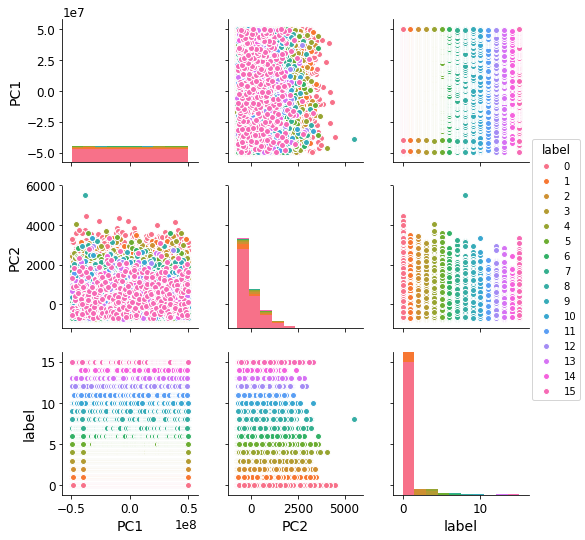

In [14]:
import seaborn as sns
sns.pairplot(full_feature_pca[1], hue='label')

## NMF

Non-negative Matrix Factorization (NMF) is a method of dimensionality reduction, feature selection, and clustering. It has many applications in text mining, image analysis, bioinformatics, and even audio signal processing. NMF creates two matrices from a given matrix by matrix factorization. Our matrix has shape (104495,103) and the defined n_components for the NMF is 20 so the result will be 1 matrix of shape (104495,20) and another matrix of shape (20, 103).

In [15]:
from sklearn.decomposition import NMF
n_components=5
nmf = NMF(n_components=n_components,random_state=1,alpha=.1, l1_ratio=.5)
nmf_fitted = nmf.fit_transform(only_features)

In [16]:
interest_list = []

In [17]:
n_top = 10
for idx, cluster in enumerate(nmf.components_):
    message = "Cluster #%d: " % idx
    message += " ".join([features[i] for i in cluster.argsort()[:-n_top - 1:-1]])
    interest_list += (features[i] for i in cluster.argsort()[:-n_top - 1:-1])
    print(message)

Cluster #0: MemberID PayDelaySum PayDelayMax PayDelayMean LabCountMax LabCountMean LabCountMin LengthOfStay.daysCount PayDelayCount PlaceSvc_Office
Cluster #1: PayDelaySum PayDelayMax PayDelayMean LengthOfStay.daysCount PayDelayCount PlaceSvc_Office ProcedureGroup_EM Specialty_Internal ProcedureGroup_MED Specialty_General Practice
Cluster #2: PayDelaySum PayDelayMax PayDelayMean LabCountMax PlaceSvc_Office LabCountMean LengthOfStay.daysCount PayDelayCount LabCountMin ProcedureGroup_EM
Cluster #3: PayDelayMean PayDelayMin PayDelayMax LabCountMax LabCountMean LabCountMin LabCountSum PayDelaySum PrimaryConditionGroup_MSC2a3 LabCountCount
Cluster #4: PayDelaySum LabCountSum PayDelayCount LengthOfStay.daysCount PlaceSvc_Independent Lab Specialty_Laboratory PayDelayMin PayDelayMax ProcedureGroup_PL PrimaryConditionGroup_MSC2a3


In [18]:
nmfKL = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)
nmfKL_fitted = nmfKL.fit_transform(only_features)

In [19]:
for idx, cluster in enumerate(nmfKL.components_):
    message = "Cluster #%d: " % idx
    message += " ".join([features[i] for i in cluster.argsort()[:-n_top - 1:-1]])
    interest_list += (features[i] for i in cluster.argsort()[:-n_top - 1:-1])
    print(message)

Cluster #0: MemberID PayDelaySum PayDelayMax PayDelayMean PayDelayMin PayDelayCount LengthOfStay.daysCount LabCountSum PlaceSvc_Office LabCountMax
Cluster #1: PayDelaySum PayDelayMax PayDelayMean PayDelayCount LengthOfStay.daysCount PlaceSvc_Office ProcedureGroup_EM LabCountSum Specialty_Internal ProcedureGroup_MED
Cluster #2: PayDelayMax PayDelayMean PayDelayMin LabCountMax LabCountMean LabCountMin LabCountSum PrimaryConditionGroup_MSC2a3 LabCountCount Specialty_General Practice
Cluster #3: PayDelayMean PayDelayMin LabCountMin LabCountMean PayDelaySum Specialty_Pediatrics PlaceSvc_Urgent Care PrimaryConditionGroup_RESPR4 PrimaryConditionGroup_INFEC4 Specialty_Emergency
Cluster #4: LabCountSum LengthOfStay.daysCount PayDelayCount PlaceSvc_Independent Lab Specialty_Laboratory LabCountMax PlaceSvc_Office ProcedureGroup_PL PrimaryConditionGroup_MSC2a3 LabCountCount


In [20]:
interest_list = pd.Series(interest_list).unique().tolist()
len(interest_list)

26

In [21]:
#We know that 'MemberID' should not be influential
interest_list.remove('MemberID')
only_interest = train_X[interest_list]

In [22]:
pca_interest = pca_var_trans(2,only_interest,train_X['DaysInHospital'])

print('Explained Variance Ratio for NMF cluster')
print ('PCA for Features of Interest from NMF: {}'.format(pca_interest[0]))

Explained Variance Ratio for NMF cluster
PCA for Features of Interest from NMF: [0.99440078 0.00398263]


Text(0.5,0.98,'NMF Selected Features')

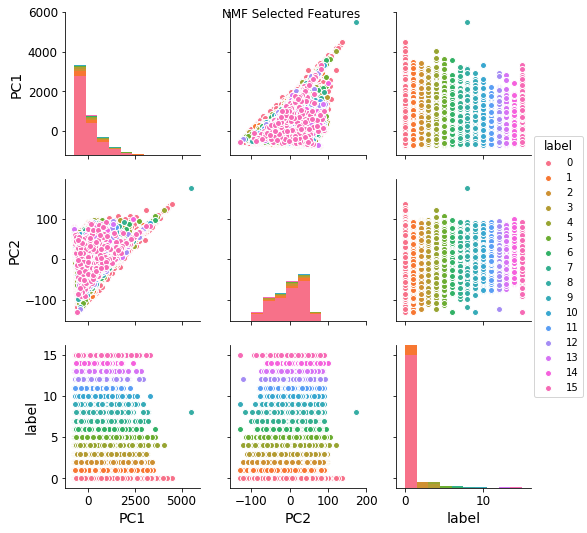

In [23]:
sns.pairplot(pca_interest[1], hue='label').fig.suptitle("NMF Selected Features")

## Multiple Histograms

It's much easier to visualize 25 variables then 103. 

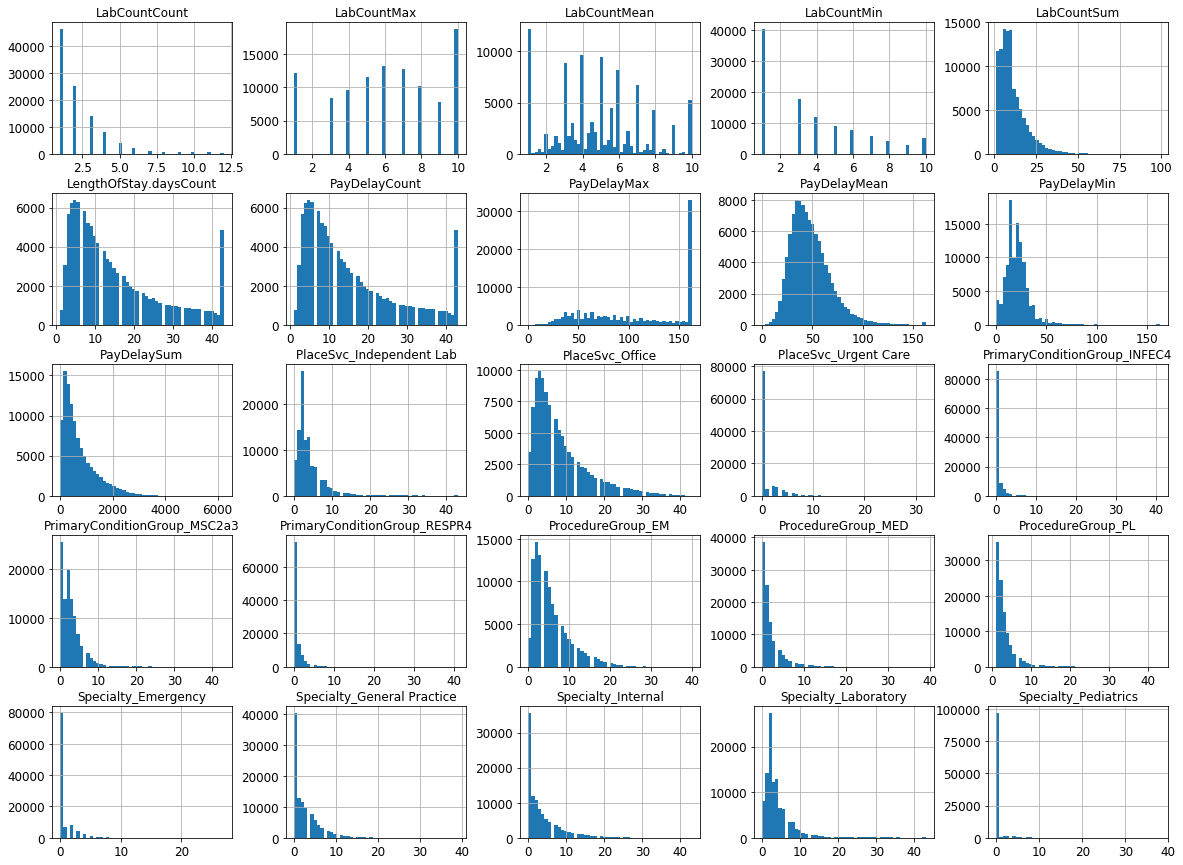

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
only_interest.hist(bins=50, figsize=(20,15))
plt.show()

In [25]:
import datashader as ds
from datashader import transfer_functions as tf
import holoviews as hv
from holoviews.operation import decimate
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize

### Datashader

I tried really hard to get the datashader plot to work but I just couldn't plot multiple variables in different colors. I probably spent 4+ hours trying so I'm leaving this here as evidence to my failure.

The example below was an attempt to follow the tutorial: [Working with large data using datashader](http://holoviews.org/user_guide/Large_Data.html)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
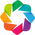

:DynamicMap   []
   :Overlay
      .NdOverlay.A_0 :NdOverlay   [Element]
         :Points   [x,y]
      .RGB.I         :RGB   [PC1,PC2]   (R,G,B,A)

In [26]:
kdims=['PC1','PC2']
num_ks=16
hv.extension('bokeh','matplotlib')


gaussians = {i: hv.Points(pca_interest[1], kdims) for i in range(num_ks)}


gaussspread = dynspread(datashade(hv.NdOverlay(gaussians, kdim='label'), aggregator=ds.count_cat('label')))

from datashader.colors import Sets1to3 # default datashade() and shade() color cycle
color_key = list(enumerate(Sets1to3[0:num_ks]))
color_points = hv.NdOverlay({k: hv.Points([0,0], label=str(k)).options(color=v) for k, v in color_key})

color_points * gaussspread

In [27]:
# Seaborn's swarmplot is not useable here, even though we only have two columns, because of the large dataset
#sns.swarmplot(x='PC1', y='PC2', data=pca_all[1])

In [28]:
train_X_labels = train_X['DaysInHospital'].copy()
#train_X = train_X.drop(['DaysInHospital'], axis=1) 
# drop labels for training set

Check for any missing values:

In [29]:
sample_incomplete_rows = train_X[train_X.isnull().any(axis=1)].head()
sample_incomplete_rows

,MemberID,LabCountCount,LabCountMean,LabCountMax,LabCountMin,LabCountSum,PayDelayCount,PayDelayMean,PayDelayMax,PayDelayMin,...,PrimaryConditionGroup_RENAL2,PrimaryConditionGroup_RENAL3,PrimaryConditionGroup_RESPR4,PrimaryConditionGroup_ROAMI,PrimaryConditionGroup_SEIZURE,PrimaryConditionGroup_SEPSIS,PrimaryConditionGroup_SKNAUT,PrimaryConditionGroup_STROKE,PrimaryConditionGroup_TRAUMA,PrimaryConditionGroup_UTI


## RFE

Recursive Feature Elimination (RFE) is a method of reducing features with the use of any classifier model to first fully fit a model with all features, then recursively remove features and recalculate the model's accuracy.

In [30]:
elasticNet_reg = ElasticNet()
SGD_reg = SGDClassifier(max_iter=3, tol=None)
log_reg = LogisticRegression()
modelList = [elasticNet_reg, SGD_reg, log_reg]

rfeList = []
for i in modelList:
    rfe = RFE(estimator=i, n_features_to_select=8, step=1)
    rfe = rfe.fit(only_interest, train_X['DaysInHospital'])
    selectedFeature = [cols[x] for x,z in enumerate(rfe.ranking_) if z==1]
    rfeList += [x for x in selectedFeature]
    print('Model: {} \nSupport: {} \nRanking: {} \nSelected Features: {} \n\n'.format(
        i,rfe.support_,rfe.ranking_,selectedFeature))

Model: ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
Support: [ True  True  True False False False  True  True False False False False
 False False  True False False False False False  True  True False False
 False] 
Ranking: [ 1  1  1  9  8  7  1  1 11 13 15 17 18 16  1  6  5  4  3  2  1  1 10 12
 14] 
Selected Features: ['MemberID', 'LabCountCount', 'LabCountMean', 'PayDelayCount', 'PayDelayMean', 'LengthOfStay.daysMin', 'ProcedureGroup_EM', 'ProcedureGroup_MED'] 


Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=3, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False) 
Support: [False  True  True

In [31]:
rfeSelList = pd.Series(rfeList).unique().tolist()
#We know that 'MemberID' should not be influential
rfeSelList.remove('MemberID')
rfe_interest = train_X[rfeSelList]

In [32]:
len(rfeSelList)

15

## Transforming Variables

Transformation of variables is important to consider for hypothesis testing and feature engineering.

In [33]:
def transform_plots(variableList):
    for title, feature in enumerate(variableList):
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        train_X[feature].hist(ax=axes[0]).set_title('Normal')
        np.log(train_X[feature]+1).hist(ax=axes[1]).set_title('Log')
        np.sqrt(train_X[feature]).hist(ax=axes[2]).set_title('Square Root')
        
        for ax in axes.flat:
            ax.set(xlabel=variableList[title], ylabel='Count')
            ax.label_outer()
        plt.show()

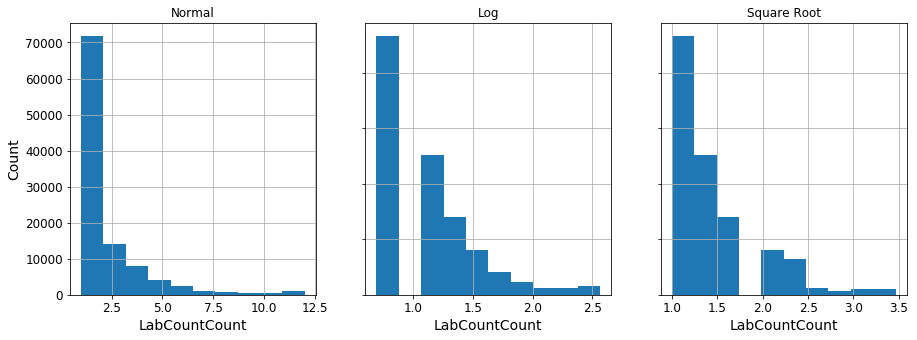

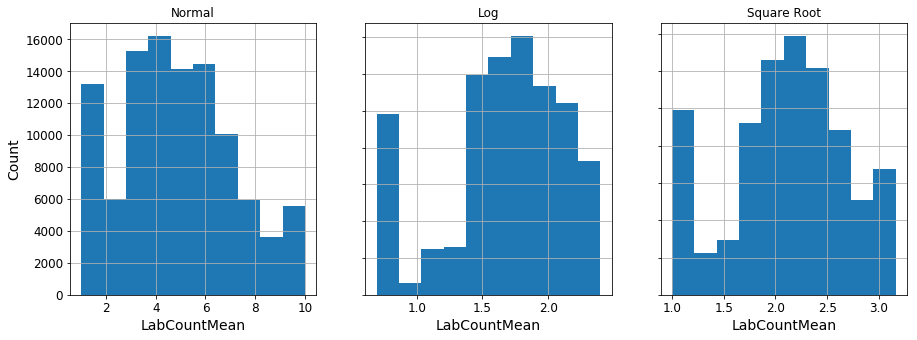

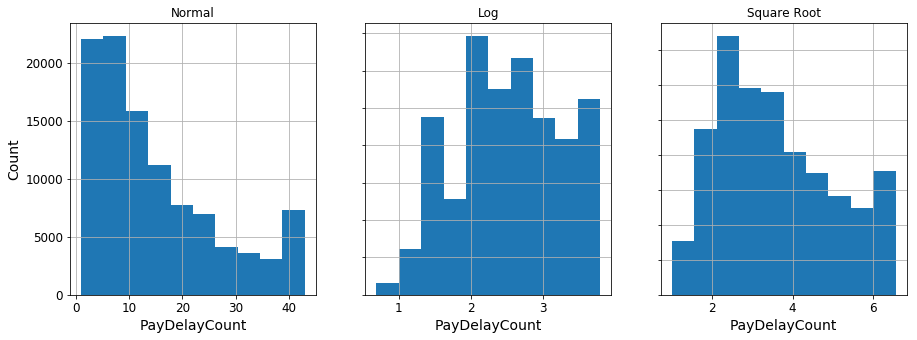

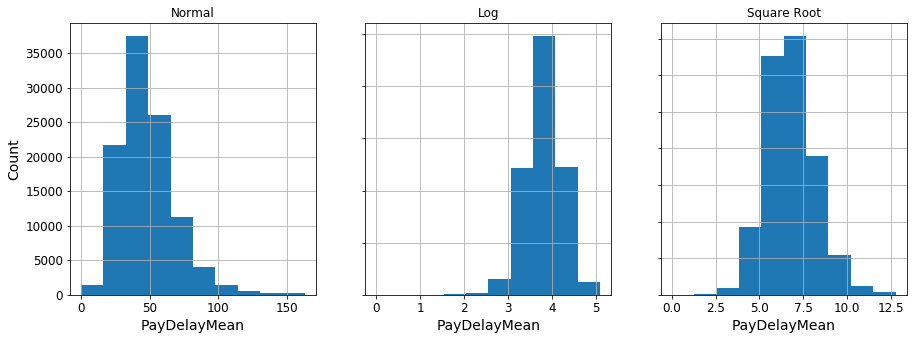

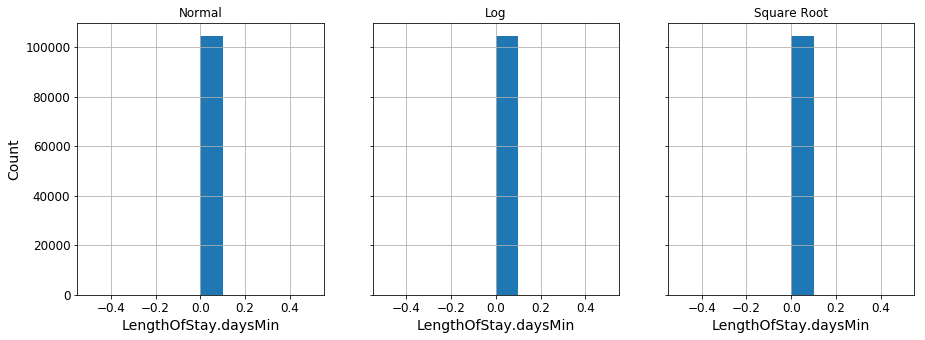

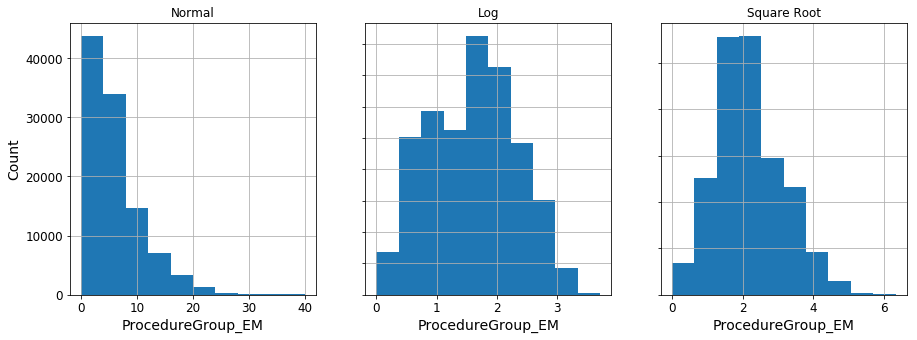

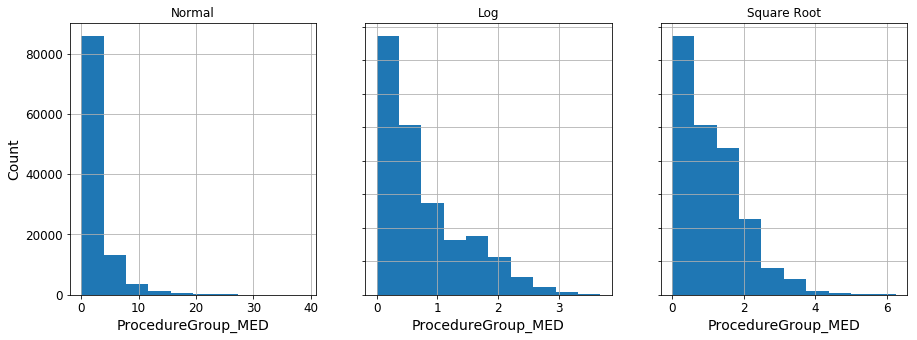

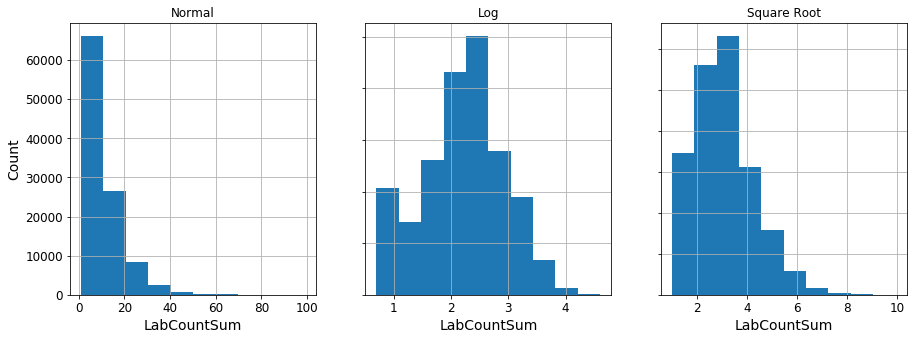

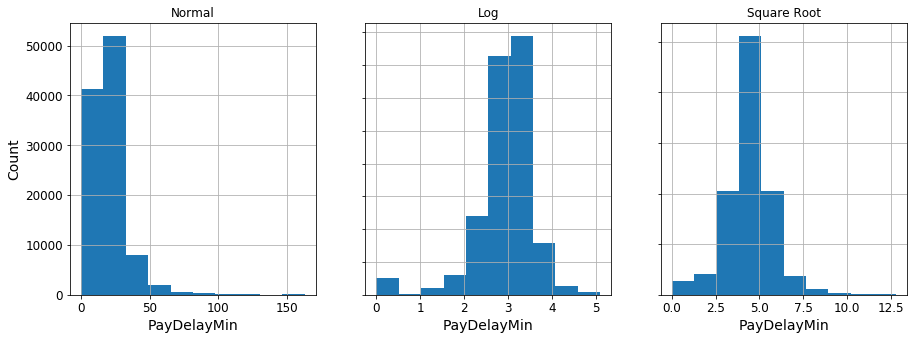

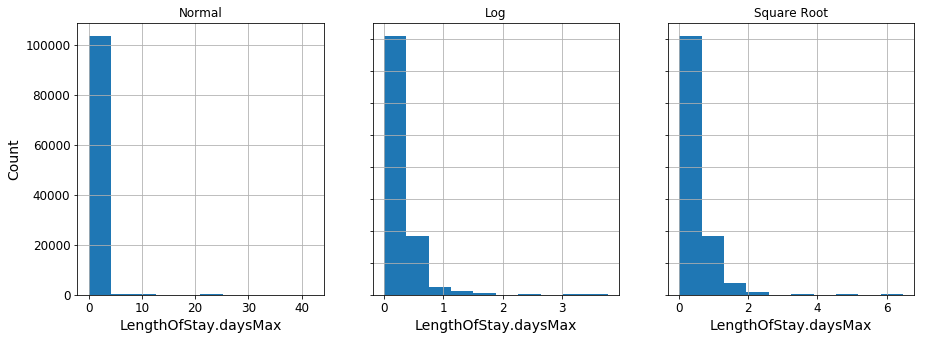

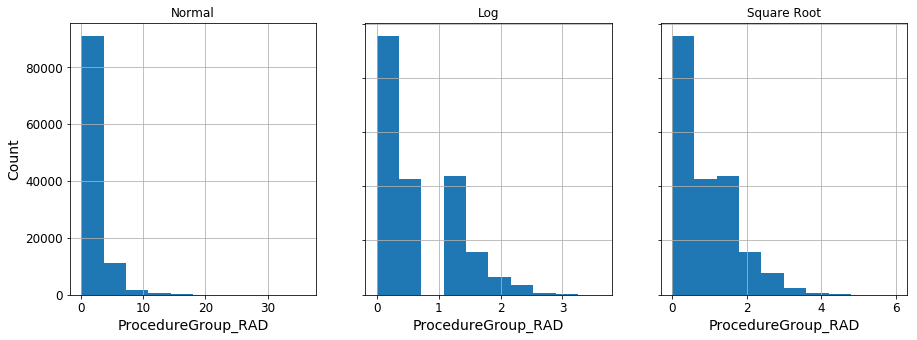

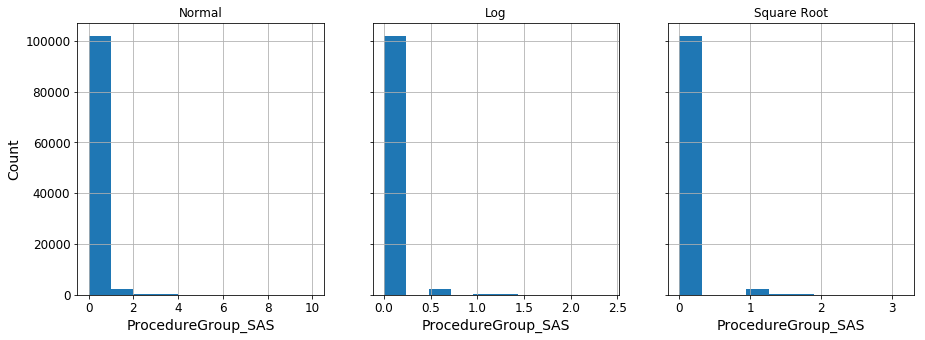

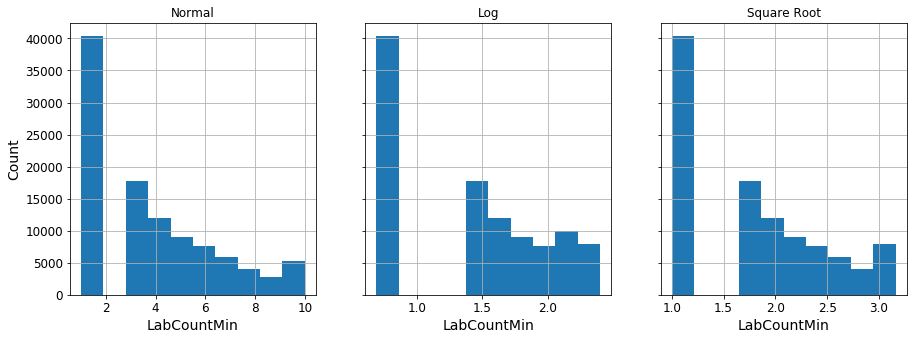

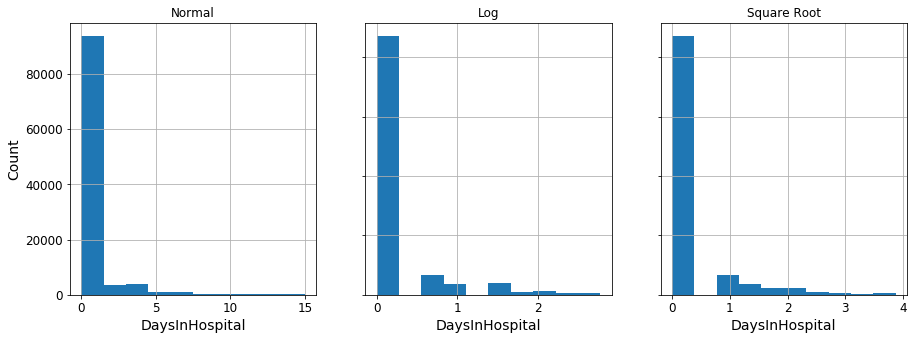

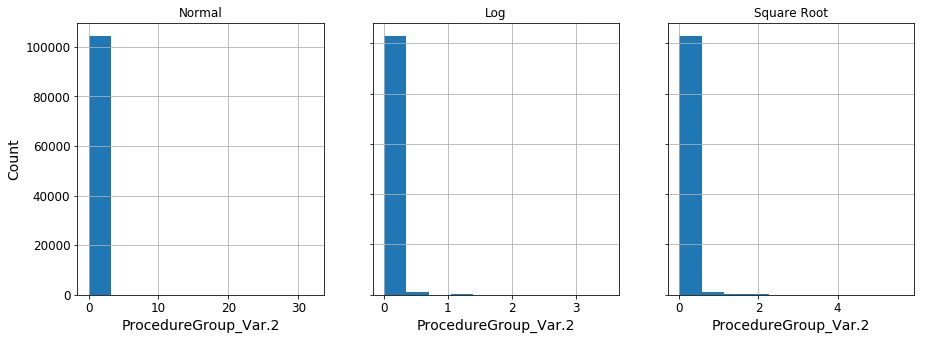

In [34]:
transform_plots(rfeSelList)

Text(0,0.5,'Num. Patients')

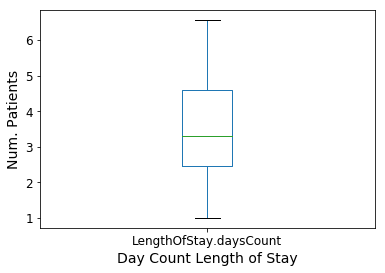

In [35]:
plot = np.sqrt(train_X['LengthOfStay.daysCount']).to_frame().boxplot(grid=False)
plot.set_xlabel('Day Count Length of Stay')
plot.set_ylabel('Num. Patients')

### EDA

A correlation matrix will show if any linear correlation exist between the label and the other variables.

In [36]:
corr_matrix = train_X.corr()
corr_matrix["DaysInHospital"].sort_values(ascending=False)

DaysInHospital                         1.000000
PayDelayCount                          0.188604
LengthOfStay.daysCount                 0.188604
ProcedureGroup_EM                      0.175871
ClaimsTruncated                        0.169226
PayDelaySum                            0.160035
Specialty_Internal                     0.143302
LabCountSum                            0.139105
Specialty_Diagnostic Imaging           0.138110
PlaceSvc_Office                        0.133845
ProcedureGroup_RAD                     0.125355
LabCountCount                          0.124395
ProcedureGroup_PL                      0.123854
PlaceSvc_Independent Lab               0.114570
Specialty_Laboratory                   0.114378
PlaceSvc_Inpatient Hospital            0.111679
Specialty_Emergency                    0.110535
ProcedureGroup_MED                     0.095289
PlaceSvc_Urgent Care                   0.094912
ProcedureGroup_SCS                     0.094130
PayDelayMax                            0

## Split into train and test

In [37]:
nmf_df = pd.DataFrame(data=only_interest).assign(label=train_X_labels)
rfe_df = pd.DataFrame(data=rfe_interest).assign(label=train_X_labels)

In [38]:
full_train, full_test = train_test_split(train_X, test_size=0.5, random_state=42)
pca_train, pca_test = train_test_split(full_feature_pca[1], test_size=0.5, random_state=42)
nmf_train, nmf_test = train_test_split(nmf_df, test_size=0.5, random_state=42)
rfe_train, rfe_test = train_test_split(rfe_df, test_size=0.5, random_state=42)

We have produced 3 datasets and will run with the full dataset:
1. Full dataset
2. PCA of the full datasets
3. NMF selected variables
4. RFE selected from NMF variables

In [39]:
print(full_train.shape)
print(pca_train.shape)
print(nmf_train.shape)
print(rfe_train.shape)

(52247, 104)
(52247, 3)
(52247, 26)
(52247, 16)


## Run pipeline to produce random prediction

The max label in our created training set is 2.772589 and the max in the dataset provided is 15. Lets create some random prediction for both to complare our models to. 

In [44]:
lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(full_train['DaysInHospital'])
y_val = lab_enc.fit_transform(full_test['DaysInHospital']   )                             

rand_pred_train = np.log(np.random.randint(0,15,np.size(y_train)) + 1)
rand_train_mse = np.sqrt(mean_squared_error(y_train, rand_pred_train))

rand_pred_test = np.log(np.random.randint(0,15,np.size(y_val)) + 1)
rand_test_mse = np.sqrt(mean_squared_error(y_val, rand_pred_test))

results = pd.DataFrame(columns=["ExpID", "Train MSE", "Test MSE", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])
results.loc[0] = ["Random Prediction", round(rand_train_mse, 4), round(rand_test_mse, 4), "---", "< 1s", "< 1s", "Numpy Random"]

In [45]:
results

,ExpID,Train MSE,Test MSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Random Prediction,2.307,2.281,---,< 1s,< 1s,Numpy Random


### Bulk Train Linear Models

In [46]:
def bulk_train_models (X_train, y_train, X_val, y_val):
    lin_res = pd.DataFrame(columns=["ExpID", "Train MSE", "Test MSE"])


    #Lasso, LinearRegression, LogisticRegression, Ridge, SGDClassifier
    regressors = [
        ('Linear', LinearRegression()),
        ('Lasso', Lasso()),
        ('Ridge', Ridge()),
        ('ElasticNet', ElasticNet()),
        ('SGD', SGDClassifier(max_iter=3, tol=None)),
        ('Logistic', LogisticRegression()),
        ('DecisionTree', DecisionTreeRegressor(random_state=42)),
        ('RandomForest', RandomForestRegressor(random_state=42))
        ]

    for idx, (name, regressor) in enumerate(regressors, 1):
        regressor.fit(X_train, y_train)
        reg_scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
        reg_score_train = np.sqrt(-1*reg_scores).mean()
        pred_test_reg = regressor.predict(X_val)
        score_test_reg = np.sqrt(mean_squared_error(y_val, pred_test_reg))

        lin_res.loc[idx] = [name, round(reg_score_train, 4), round(score_test_reg, 4)]
    return lin_res


### Full Model Results

In [47]:
bulk_train_models(full_train.drop(['DaysInHospital'], axis=1),lab_enc.fit_transform(full_train['DaysInHospital'])
                  , full_test.drop(['DaysInHospital'], axis=1), lab_enc.fit_transform(full_test['DaysInHospital']))

c:\users\tiffany.fabianac\appdata\local\programs\python\python36\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.278199282102321e-21 / 1.1102230246251565e-16
  RuntimeWarning)
c:\users\tiffany.fabianac\appdata\local\programs\python\python36\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.183964051132043e-21 / 1.1102230246251565e-16
  RuntimeWarning)
c:\users\tiffany.fabianac\appdata\local\programs\python\python36\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.199037240246889e-21 / 1.1102230246251565e-16
  RuntimeWarning)
c:\users\tiffany.fabianac\appdata\

,ExpID,Train MSE,Test MSE
1,Linear,1.6737,1.6299
2,Lasso,1.6981,1.6551
3,Ridge,1.6737,1.6299
4,ElasticNet,1.6955,1.6521
5,SGD,2.5934,1.7578
6,Logistic,1.8003,1.7578
7,DecisionTree,2.3953,2.4068
8,RandomForest,1.7784,1.7481


### Full PCA Results

In [48]:
bulk_train_models(pca_train.drop(['label'], axis=1),lab_enc.fit_transform(pca_train['label'])
                  , pca_test.drop(['label'], axis=1), lab_enc.fit_transform(pca_test['label']))

,ExpID,Train MSE,Test MSE
1,Linear,1.7006,1.6579
2,Lasso,1.7006,1.6579
3,Ridge,1.7006,1.6579
4,ElasticNet,1.7006,1.6579
5,SGD,7.6734,10.4006
6,Logistic,2.6887,3.8969
7,DecisionTree,2.4556,2.4193
8,RandomForest,1.8765,1.8471


### NMF Selected

In [49]:
bulk_train_models(nmf_train.drop(['label'], axis=1),lab_enc.fit_transform(nmf_train['label'])
                  , nmf_test.drop(['label'], axis=1), lab_enc.fit_transform(nmf_test['label']))

,ExpID,Train MSE,Test MSE
1,Linear,1.6853,1.6396
2,Lasso,1.6980,1.6551
3,Ridge,1.6853,1.6396
4,ElasticNet,1.6955,1.6521
5,SGD,2.4782,1.6837
6,Logistic,1.7998,1.7577
7,DecisionTree,2.5148,2.5858
8,RandomForest,1.8294,1.7868


### RFE Selected

In [50]:
bulk_train_models(rfe_train.drop(['label'], axis=1),lab_enc.fit_transform(rfe_train['label'])
                  , rfe_test.drop(['label'], axis=1), lab_enc.fit_transform(rfe_test['label']))

,ExpID,Train MSE,Test MSE
1,Linear,0.0000,0.0000
2,Lasso,0.5806,0.5659
3,Ridge,0.0000,0.0000
4,ElasticNet,0.4976,0.4847
5,SGD,1.3271,1.2528
6,Logistic,1.0818,1.0651
7,DecisionTree,0.0000,0.0000
8,RandomForest,0.0000,0.0000


The RFE selected variables do well, but an MSE of 0 likely indicates overfitting. 